## Table of Contents <a id='head'></a>

<a href='#fit_rf1'> Experiment 1 RandomForest Model</a>

<a href='#rf_hyper'> Experiment 2 Hyper parameter tuning with RF model</a>

<a href='#rf_up_sample'> Experiment 3 Random Search CV with Up Sample </a>

# Data Preparation

In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')
print(train_data.shape)
print(test_data.shape)

(8000, 22)
(3799, 21)


In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_data_x = train_data.copy()
train_data_x = train_data_x.drop(['Id_old', 'Id'], axis=1)
train_data_target = train_data_x.pop('TARGET_5Yrs')

test_data_x = test_data.drop(['Id_old', 'Id'], axis=1)

scaler = StandardScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(train_data_x), columns=train_data_x.columns)
df_test_scaled = pd.DataFrame(scaler.fit_transform(test_data_x), columns=test_data_x.columns)

X_data, X_test, y_data, y_test = train_test_split(df_train_scaled, train_data_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print(train_data.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(8000, 22)
(5120, 19)
(1280, 19)
(1600, 19)


# Experiment 1 Fit RandomForests Model <a id='fit_rf1'></a>

In [32]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

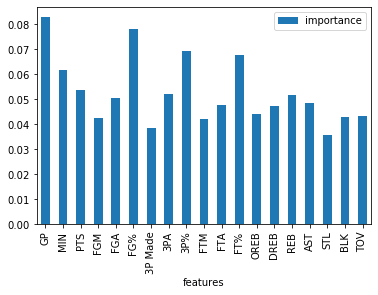

In [33]:
feature_imp = pd.DataFrame({'features':X_train.columns, 'importance':clf.feature_importances_})
feature_imp.plot.bar(x='features', y='importance')

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_val, clf.predict_proba(X_val)[:,1])

0.7082618658836121

### Majority of predictions are 1s

In [35]:
pred = clf.predict(X_test)
print(pred.shape)
print(np.sum(pred))

(1600,)
1568


# Experiment 2 Hyper parameter tuning with RF model <a id='rf_hyper'></a>

In [36]:
from sklearn.model_selection import RandomizedSearchCV

n_est = [int(x) for x in np.linspace(start=200, stop=2000, num=100)]
max_depth = [int(x) for x in np.linspace(2, 10, num=1)]
min_samples_split = [2,5,10]
bootstrap = [True, False]
class_weight = [None, 'balanced']

random_grid = {'n_estimators':n_est,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'bootstrap': bootstrap,
              'class_weight': class_weight}

In [ ]:
clf = RandomForestClassifier()
rf_rcv = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring='roc_auc')
rf_rcv.fit(X_train, y_train)

In [29]:
roc_auc_score(y_val, rf_rcv.predict_proba(X_val)[:,1])

0.7072327346076265

#### All predictions are 1s!

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

pred = rf_rcv.predict_proba(X_test)[:,1]
predx = [x for x in pred > 0.5]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_test, pred),3)}')

print(confusion_matrix(y_test, predx))
print(recall_score(y_test, predx))
print(accuracy_score(y_test, predx))
print(balanced_accuracy_score(y_test, predx))
print(f1_score(y_test, predx))

1600 out of 1600 or 100% of players are predicted to be 5+ Yrs
ROC_AUC Score: 0.708
[[   0  263]
 [   0 1337]]
1.0
0.835625
0.5
0.9104528430371127


#### Add thresthold to force 0s in data
Training set

In [18]:
thr = 0.8
pred = rf_rcv.predict_proba(X_train)[:,1]
predx = [x for x in pred > thr]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_train, predx),3)}')

print(confusion_matrix(y_train, predx))
print(accuracy_score(y_train, predx))
print(f1_score(y_train, predx))

3530 out of 5120 or 69% of players are predicted to be 5Yrs
ROC_AUC Score: 0.628
[[ 453  412]
 [1137 3118]]
0.6974609375
0.8010276172125882


Validation set

In [19]:
thr = 0.8
pred = rf_rcv.predict_proba(X_val)[:,1]
predx = [x for x in pred > thr]
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_val, pred),3)}')

print(confusion_matrix(y_val, predx))
print(recall_score(y_val, predx))
print(accuracy_score(y_val, predx))
print(balanced_accuracy_score(y_val, predx))
print(f1_score(y_val, predx))

899 out of 1280 or 70% of players are predicted to be 5Yrs
ROC_AUC Score: 0.701
[[105  98]
 [276 801]]
0.7437325905292479
0.7078125
0.6304869849197964
0.8107287449392712


# Experiment 3: up sample with RF model <a id='rf_up_sample'></a>

In [38]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X_train, y_train)

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: TARGET_5Yrs, dtype: float64

In [39]:
clf = RandomForestClassifier()
rf_rcv_sm = RandomizedSearchCV(estimator=clf, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_rcv_sm.fit(X_sm, y_sm)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [None, 'balanced'],
                                        'max_depth': [2],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 218, 236, 254,
                                                         272, 290, 309, 327,
                                                         345, 363, 381, 400,
                                                         418, 436, 454, 472,
                                                         490, 509, 527, 545,
                                                         563, 581, 600, 618,
                                                         636, 654, 672, 690,
                                                         709, 727, ...]},
         

In [49]:
thr = 0.5
pred = rf_rcv_sm.predict_proba(X_val)[:,1]
predx = [x for x in pred > thr]

print(rf_rcv_sm.best_params_)
print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_val, pred),3)}')

print(confusion_matrix(y_val, predx))
print(recall_score(y_val, predx))
print(accuracy_score(y_val, predx))
print(balanced_accuracy_score(y_val, predx))
print(f1_score(y_val, predx))

{'n_estimators': 927, 'min_samples_split': 10, 'max_depth': 2, 'class_weight': None, 'bootstrap': True}
776 out of 1280 or 61% of players are predicted to be 5+ Yrs
ROC_AUC Score: 0.71
[[131  72]
 [373 704]]
0.6536675951717734
0.65234375
0.6494938961080542
0.7598488936859147


In [30]:
submission = rf_rcv_sm.predict_proba(test_data_x)[:,1]
submission = pd.DataFrame({'Id':test_data['Id'], 'TARGET_5Yrs':submission})
submission.to_csv("../data/submission/0203_rf_pred.csv", index=False)

# Experiment 4: limit important features <a id='rf_reduce_features'></a>

In [76]:
sel_col = ['GP', 'FG%', '3P%', 'FT%']
X_train_reduce = df_train_scaled[sel_col]
X_val_reduce = X_val[sel_col]
X_test_reduce = df_test_scaled[sel_col]

In [77]:
clf = RandomForestClassifier(n_estimators=927, min_samples_split=10, max_depth=2, class_weight=None, bootstrap=True).fit(X_train_reduce, train_data_target)

In [78]:
thr = 0.8
pred = clf.predict_proba(X_val_reduce)[:,1]
predx = [x for x in pred > thr]

print(f'{np.sum(predx)} out of {len(predx)} or {int(round(np.sum(predx)/len(predx)*100,0))}% of players are predicted to be 5+ Yrs')
print(f'ROC_AUC Score: {round(roc_auc_score(y_val, pred),3)}')

print(confusion_matrix(y_val, predx))
print(recall_score(y_val, predx))
print(accuracy_score(y_val, predx))
print(balanced_accuracy_score(y_val, predx))
print(f1_score(y_val, predx))

894 out of 1280 or 70% of players are predicted to be 5+ Yrs
ROC_AUC Score: 0.717
[[112  91]
 [274 803]]
0.7455896007428041
0.71484375
0.6486568693369192
0.8148148148148149


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.717


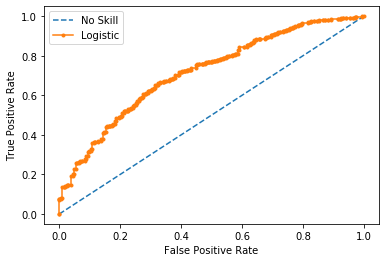

In [79]:
import sys
sys.path.append("/home/jovyan/work")

from src.visualization.visualize import plot_roc_curve
plot_roc_curve(pred, y_val)

In [80]:
submission = clf.predict_proba(X_test_reduce)[:,1]
submission = pd.DataFrame({'Id':test_data['Id'], 'TARGET_5Yrs':submission})
submission.to_csv("../data/submission/0203_rf_reduced_pred.csv", index=False)